# Visualizing Population Based Training (PBT) Hyperparameter Optimization

This tutorial will go through a simple example that will help you develop a better understanding of what PBT is doing in the backend when using it to tune your algorithms.

**Assumptions:** The reader has a basic understanding of the PBT algorithm and wants to understand and verify the underlying algorithm behavior. [This guide]() gives the necessary background.

We will learn how to: **set up checkpointing and loading for PBT** with the functional trainable interface, **configure PBT parameters**, and finally **visualize PBT algorithm behavior.**

## Example Code

You can find the code we used for this tutorial [here on Github]().

## Set up Toy the Example

The toy example optimization problem we will use comes from the [PBT paper](https://arxiv.org/pdf/1711.09846.pdf) (see Figure 2 for more details). The goal is to find parameters that maximize an quadratic function, while only having access to an estimator that depends on a set of hyperparameters. A practical example of this is maximizing the (unknown) generalization capabilities of a model across all possible inputs with only access to the empirical loss of your model, which depends on hyperparameters in order to optimize.

We'll start with some imports.

In [1]:
!pip install -U "ray[tune]"

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time

import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.tune_config import TuneConfig
from ray.air.config import FailureConfig, RunConfig
from ray.tune.tuner import Tuner

from pbt_visualization_utils import (
    get_init_theta, plot_parameter_history,
    plot_Q_history, make_animation
)

Concretely, we will use the definitions (with very minor modifications) provided in the [paper](https://arxiv.org/pdf/1711.09846.pdf) for the function we are trying to optimize, and the estimator we are given.

Here is a list of the concepts we will use for the example, and what they might be analagous to in practice:

| Concept within this example | Description | Practical analogy |
|---------|-------------|-------------------|
|`theta = [theta0, theta1]`|The model parameters that we will update in our training loop.|Neural network parameters|
|`h = [h0, h1]`|The hyperparameters that PBT will optimize.|Learning rate, batch size, etc.|
|`Q(theta)`|The quadratic function we are trying to maximize.|Generalization capability over all inputs|
|`Qhat(theta \| h)`|The estimator we are given as our training objective, depends (`\|`) on `h`.|Empirical loss/reward|

Below are the implementations in code.

In [3]:
def Q(theta):
    return 1.2 - (3/4 * theta[0] ** 2 + theta[1] ** 2)

def Qhat(theta, h):
    return 1.2 - (h[0] * theta[0] ** 2 + h[1] * theta[1] ** 2)

def grad_Qhat(theta, h):
    theta_grad = -2 * h * theta
    theta_grad[0] *= 3/4
    h_grad = -np.square(theta)
    h_grad[0] *= 3/4
    return {"theta": theta_grad, "h": h_grad}

theta_0 = get_init_theta()
print("Initial parameter values: theta = ", theta_0)

Initial parameter values: theta =  [0.9 0.9]


## Defining the Function Trainable

We will define the training loop, which will:
1. Load the hyperparameter configuration
2. Initialize the model, resuming from a checkpoint if applicable (this is important for PBT, since the scheduler will pause and resume trials frequently).
3. Run the training loop and checkpoint.

In [4]:
def train_func(config):
    # Load the hyperparam config passed in by the Tuner
    h0 = config.get("h0")
    h1 = config.get("h1")
    h = np.array([h0, h1]).astype(float)
    
    lr = config.get("lr")
    train_step = 1
    checkpoint_interval = config.get("checkpoint_interval", 1)
    logging_interval = config.get("logging_interval", 10)
    
    # Initialize the model parameters
    theta = get_init_theta()
    
    # Load a checkpoint if it exists
    # This checkpoint could be a trial's own checkpoint to resume,
    # or another trial's checkpoint placed by PBT that we will exploit
    if session.get_checkpoint():
        checkpoint_dict = session.get_checkpoint().to_dict()
        # Load in model (theta)
        theta = checkpoint_dict["theta"]
        train_step = checkpoint_dict["train_step"] + 1
    
    # Main training loop (trial stopping handled by Tune scheduler)
    while True:
        # Perform gradient ascent steps
        param_grads = grad_Qhat(theta, h)
        theta_grad = np.asarray(param_grads["theta"])
        theta = theta + lr * theta_grad
        
        # Checkpoint every `checkpoint_interval` steps
        checkpoint = None
        should_checkpoint = train_step % checkpoint_interval == 0
        if should_checkpoint:
            checkpoint = Checkpoint.from_dict({
                "h": h,
                "train_step": train_step,
                "theta": theta,
            })

        # Define which custom metrics we want in our trial result
        result = {
            "Q": Q(theta),
            "theta0": theta[0], "theta1": theta[1],
            "h0": h0, "h1": h1,
            "train_step": train_step,
        }
        
        # Report metric for this training iteration, and include the
        # trial checkpoint that contains the current parameters if we
        # saved it this train step
        session.report(result, checkpoint=checkpoint)
        
        train_step += 1

## Configure PBT and Tuner

We start by initializing ray (shutting it down if a session existed previously).

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

### Create the PBT scheduler

In [6]:
perturbation_interval = 4

pbt_scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    quantile_fraction=0.5,
    resample_probability=0.5,
    hyperparam_mutations={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.uniform(0., 1.),
        "h1": tune.uniform(0., 1.),
    },
    synch=True,
)

A few notes on the PBT config:
- `time_attr="training_iteration"` in combination with `perturbation_interval=4` will decide whether a trial should continue or exploit a different trial every 4 training steps.
- `hyperparam_mutations` specifies that the learning rate `lr` and additional hyperparameters `h0`, `h1` should be mutated by PBT and defines the resample distribution for each hyperparameter.
- `synch=True` means PBT will run synchronously, which introduces extra overhead but produces more understandable visualizations for the purposes of this tutorial. Feel free to try changing it to `synch=False` on this notebook to see the asynch behavior!

### Create the Tuner

In [7]:
tuner = Tuner(
    train_func,
    param_space={
        "lr": 0.05,
        "h0": tune.grid_search([0.0, 1.0]),
        "h1": tune.sample_from(lambda spec: 1. - spec.config["h0"]),
        "num_training_iterations": 100,
        # Match `checkpoint_interval` with `perturbation_interval`
        "checkpoint_interval": perturbation_interval,
    },
    tune_config=TuneConfig(
        num_samples=1,
        metric="Q", mode="max",
        # Set the PBT scheduler in this config
        scheduler=pbt_scheduler,
    ),
    run_config=RunConfig(
        stop={"training_iteration": 100},
        failure_config=FailureConfig(max_failures=3),
    ),
)

```{note}
We recommend matching `checkpoint_interval` with `perturbation_interval` from the PBT config.
This ensures that the PBT algorithm actually exploits the trials in the most recent iteration.

If your `perturbation_interval` is large and want to checkpoint more frequently, set `perturbation_interval` to be a multiple of `checkpoint_interval`.
```

A few other notes on the Tuner config:
- `param_space` specifies the *initial* `config` input to our training function. A `grid_search` over two values will launch two trials with a certain set of hyperparameters, and PBT will continue modifying them as training progresses.
- The initial hyperparam settings for `h0` are configured so that two trials will spawn, one with `h = [1, 0]` and the other with `h = [0, 1]`. This matches the paper experiment and will be used to compare against a `grid_search` baseline that removes the PBT scheduler.

## Run the experiment

In [ ]:
pbt_results = tuner.fit()

## Visualize results

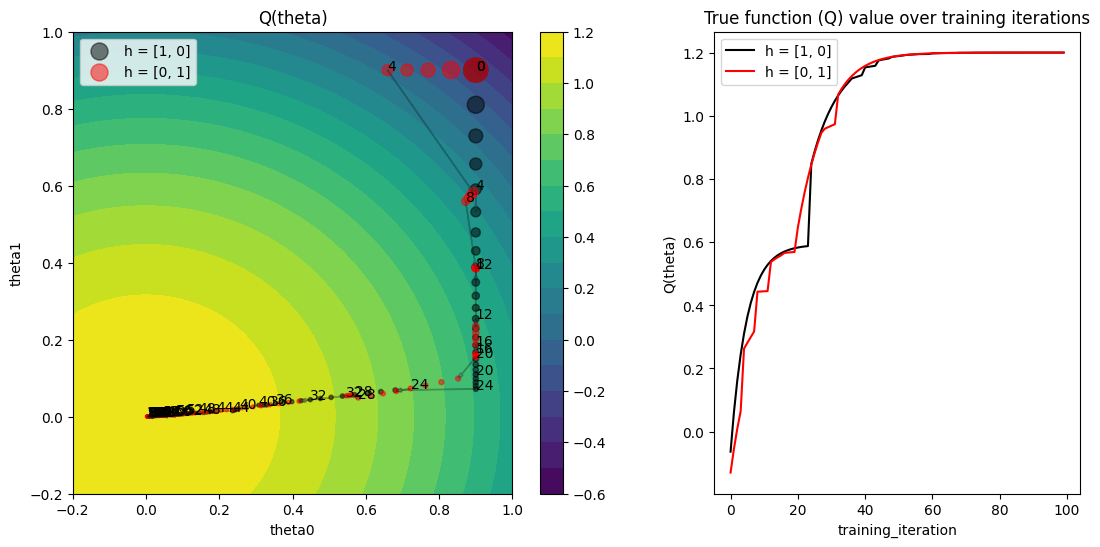

In [9]:
fig, axs = plt.subplots(
    1, 2, figsize=(13, 6),
    gridspec_kw=dict(width_ratios=[1.5, 1])
)

colors = ["black", "red"]
labels = ["h = [1, 0]", "h = [0, 1]"]

plot_parameter_history(
    pbt_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig, ax=axs[0],
)
plot_Q_history(
    pbt_results,
    colors,
    labels,
    ax=axs[1]
)

The plot on the right shows the true function value `Q(theta)` as training progresses for both trials.

Here's how to understand the plot on the left:
- The plot on the left shows the parameter values `(theta0, theta1)` on every training iteration, for both trials. As the training iteration increases, the size of the point gets smaller.
- We see the iteration shown as a label next to points at every `perturbation_interval` training iterations.
    - At these points, we see that a trial either continues (see iteration 4 to 5 for the red trial) or exploits and perturbs the other trial and performs a train step (see iteration 4 to 5 for the black trial).
    - The gradient direction also changes at this step for the black trial due to the hyperparameters changing from the exploit and explore steps of PBT.

### Animate the training progress

In [19]:
make_animation(
    pbt_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    filename="pbt.gif"
)

We can also animate the training progress to see what's happening to the model parameters at each step.

![PBT Visualization GIF](pbt.gif)

## Grid Search Comparison

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

tuner = Tuner(
    train_func,
    param_space={
        "lr": tune.qloguniform(1e-2, 1e-1, 5e-3),
        "h0": tune.grid_search([0.0, 1.0]),
        "h1": tune.sample_from(lambda spec: 1. - spec.config["h0"]),
    },
    tune_config=TuneConfig(
        num_samples=1, metric="Q", mode="max",
    ),
    run_config=RunConfig(
        stop={"training_iteration": 100},
        failure_config=FailureConfig(max_failures=3),
    ),
)

grid_results = tuner.fit()
if grid_results.errors:
    raise RuntimeError

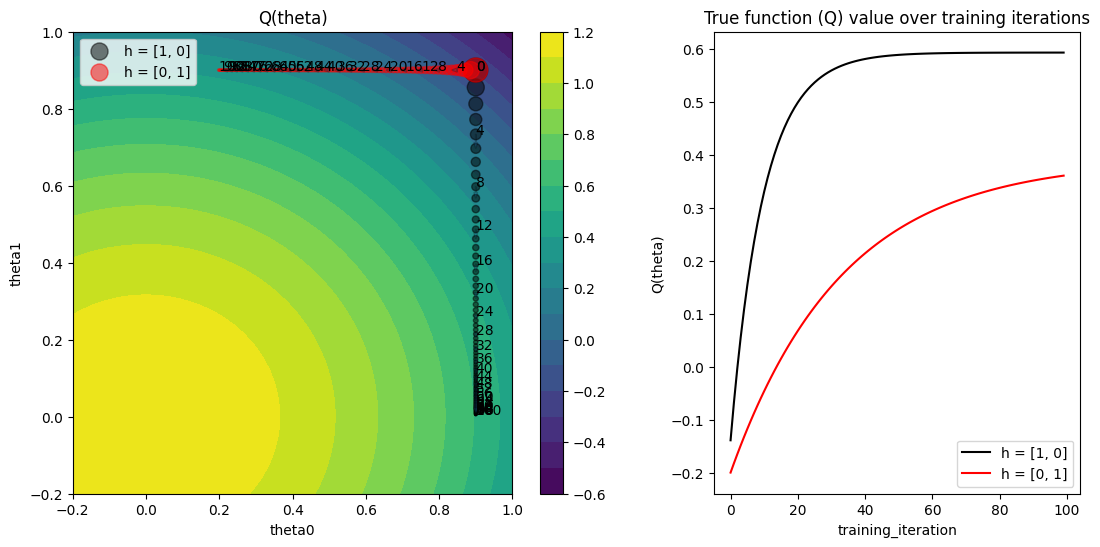

In [12]:
fig, axs = plt.subplots(
    1, 2, figsize=(13, 6),
    gridspec_kw=dict(width_ratios=[1.5, 1])
)

colors = ["black", "red"]
labels = ["h = [1, 0]", "h = [0, 1]"]

plot_parameter_history(
    grid_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig, ax=axs[0],
)
plot_Q_history(
    grid_results,
    colors,
    labels,
    ax=axs[1]
)

## Increase PBT population size

One last experiment: what does it look like if we increase the PBT population size? Now, low-performing trials will sample one of the high-performing trials to exploit, and it should result in some more interesting behavior.

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init()
perturbation_interval = 4
pbt_scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    quantile_fraction=0.5,
    resample_probability=0.5,
    hyperparam_mutations={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.uniform(0., 1.),
        "h1": tune.uniform(0., 1.),
    },
    synch=True,
)
tuner = Tuner(
    train_func,
    param_space={
        "lr": tune.qloguniform(5e-3, 1e-1, 5e-4),
        "h0": tune.grid_search([0.0, 1.0, 0.01, 0.99]), # 4 trials
        "h1": tune.sample_from(lambda spec: 1. - spec.config["h0"]),
        "num_training_iterations": 100,
        "checkpoint_interval": perturbation_interval,
    },
    tune_config=TuneConfig(
        num_samples=1,
        metric="Q", mode="max",
        # Set the PBT scheduler in this config
        scheduler=pbt_scheduler,
    ),
    run_config=RunConfig(
        stop={"training_iteration": 100},
        failure_config=FailureConfig(max_failures=3),
    ),
)
pbt_4_results = tuner.fit()

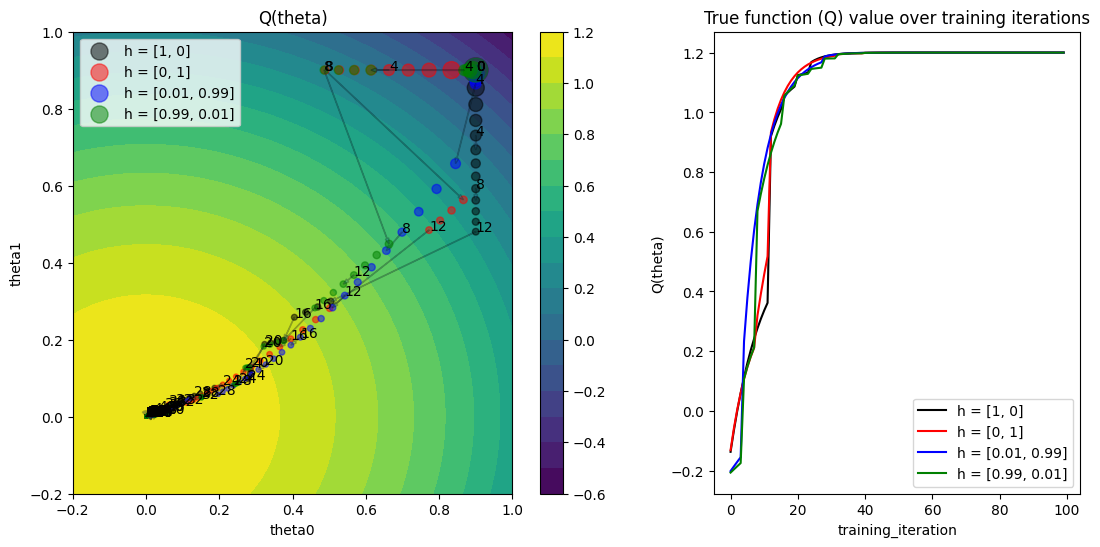

In [18]:
fig, axs = plt.subplots(
    1, 2, figsize=(13, 6),
    gridspec_kw=dict(width_ratios=[1.5, 1])
)

colors = ["black", "red", "blue", "green"]
labels = ["h = [1, 0]", "h = [0, 1]", "h = [0.01, 0.99]", "h = [0.99, 0.01]"]

plot_parameter_history(
    pbt_4_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    fig=fig, ax=axs[0],
)
plot_Q_history(
    pbt_4_results,
    colors,
    labels,
    ax=axs[1]
)

In [23]:
make_animation(
    pbt_4_results,
    colors,
    labels,
    perturbation_interval=perturbation_interval,
    filename="pbt4.gif"
)

![PBT 4 Trial Visualization](pbt4.gif)